In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import scipy.io
import tensorflow as tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Compiling model...
Building feed-forward neural network...
'build' took 0.045185 s



/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
2023-09-04 15:31:57.415835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.256595 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.57e-04, 1.78e+00, 4.56e+00]    [7.57e-04, 1.78e+00, 4.56e+00]    [2.66e+00]    


2023-09-04 15:31:57.632771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [1.17e-04, 5.57e-07, 2.23e-05]    [1.17e-04, 5.57e-07, 2.23e-05]    [4.04e-01]    
2000      [5.55e-05, 6.20e-07, 4.37e-06]    [5.55e-05, 6.20e-07, 4.37e-06]    [3.21e-01]    
3000      [3.63e-05, 4.97e-07, 1.75e-06]    [3.63e-05, 4.97e-07, 1.75e-06]    [2.60e-01]    
4000      [2.37e-05, 1.68e-07, 8.33e-07]    [2.37e-05, 1.68e-07, 8.33e-07]    [2.10e-01]    
5000      [1.76e-05, 6.10e-08, 4.77e-07]    [1.76e-05, 6.10e-08, 4.77e-07]    [1.86e-01]    
6000      [1.28e-05, 3.67e-09, 2.65e-07]    [1.28e-05, 3.67e-09, 2.65e-07]    [1.63e-01]    
7000      [1.03e-05, 9.39e-09, 1.69e-07]    [1.03e-05, 9.39e-09, 1.69e-07]    [1.48e-01]    
8000      [7.95e-06, 1.90e-06, 1.22e-05]    [7.95e-06, 1.90e-06, 1.22e-05]    [1.31e-01]    
9000      [6.45e-06, 2.11e-07, 4.11e-06]    [6.45e-06, 2.11e-07, 4.11e-06]    [1.19e-01]    
10000     [4.43e-06, 1.45e-08, 5.80e-08]    [4.43e-06, 1.45e-08, 5.80e-08]    [1.02e-01]    
11000     [2.42e-06, 4.98e-06, 7.15e-07]    [2.42e-06, 4.98e-06, 7.15e

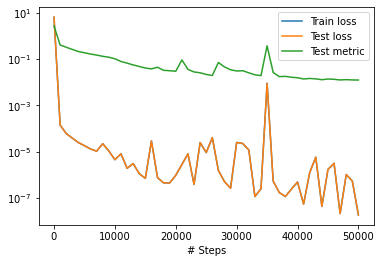

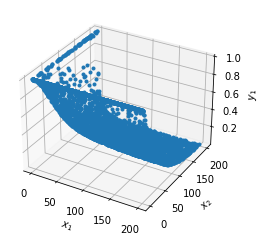

In [2]:
def PDE(x,y):
    
    # x[0]=x,x[1]=t
    a = 688
    b = 40.1
    
    dy_t = dde.grad.jacobian(y, x,i=0,j=1)
    
    k2 = x[:,0:1]/(a+b*x[:,0:1])
    
    eq1 =  k2*y + dy_t
 
    return eq1

def solution1(x,t):
    a = 688
    b = 40.1
    
    y= np.exp(-x*t/(a+b*x))
    
    return y



geom = dde.geometry.Interval(0, 200)
timedomain = dde.geometry.TimeDomain(0, 200)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def func(x):
    return 1


bc = dde.icbc.DirichletBC(geomtime, func, boundary)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 1,
    lambda _, on_initial: on_initial,
)


def func1(x):
    
    return solution1(x[:,0:1],x[:,1:2])

data = dde.data.TimePDE(geomtime, PDE, [bc,ic] , 3500, 100,train_distribution='pseudo',solution=func1, num_initial=600, num_test=None)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.PFNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001,metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=50000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [3]:
import pandas as pd
test1=np.loadtxt('test.dat', unpack = True)
df = pd.DataFrame(test1.T, columns = ['x','t','exact','predict'])
df

,x,t,exact,predict
0,0.000000,107.220711,1.000000,0.999930
1,0.000000,180.024841,1.000000,0.999917
2,0.000000,162.627090,1.000000,0.999930
3,0.000000,53.559216,1.000000,0.999934
4,0.000000,160.370956,1.000000,0.999931
...,...,...,...,...
4837,61.042946,27.098406,0.590074,0.591011
4838,84.356850,96.800613,0.134527,0.136167
4839,39.700684,160.442841,0.061193,0.062888
4840,67.733307,70.349297,0.246652,0.249195


/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'


Text(23.875, 0.5, 'shear rate')

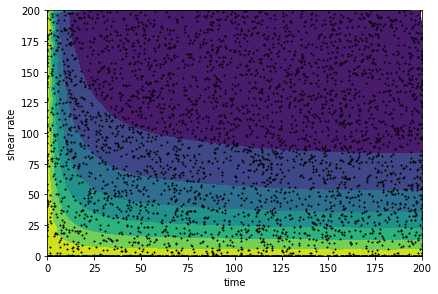

In [4]:
import pandas as pd
train1=np.loadtxt('train.dat', unpack = True)
train1 = pd.DataFrame(train1.T)
test1=np.loadtxt('test.dat', unpack = True)
df = pd.DataFrame(test1.T, columns = ['x','y','u','s'])
x = df['x']
y = df['y']
ext = df['u']
pre = df['s']
from scipy.interpolate import griddata
N = 1000; 
#npts = 2000*2000

# grid_x,grid_y = np.meshgrid(np.linspace(x.min(),x.max(),N),np.linspace(y.min(),y.max(),N))
grid_x,grid_y = np.meshgrid(np.linspace(0,200,N),np.linspace(0,200,N))
# grid_x1,grid_y1 = np.meshgrid(np.linspace(0,1,500),np.linspace(0,1,500))

#px, py = np.random.choice(x, npts), np.random.choice(y, npts)
grid_ext = griddata((x,y) ,ext, (grid_x, grid_y), method='linear')
grid_pre = griddata((x,y) ,pre, (grid_x, grid_y), method='linear')

grid_err = grid_pre-grid_ext

rng = np.random.default_rng()
# points = rng.random((1000, 2))

# a=np.zeros(1000)
# a[:]=np.nan
# grid_z2 = griddata(points ,  a , (grid_x1, grid_y1), method='cubic')
#grid_z1[999:2000,999:2000]=0
#scipy.interpolate.griddata(X,Y,X**2+Y**2,XI,YI)
plt.contourf(grid_x,grid_y, grid_pre,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.scatter(train1[0],train1[1],c='black',s=1)
# plt.scatter(test1[0],test1[1],c='yellow',s=1)
# plt.axis('equal')
plt.tight_layout()
# plt.axis('off')
plt.xlabel('time')
plt.xlim(0,200)
plt.ylabel('shear rate')


/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  


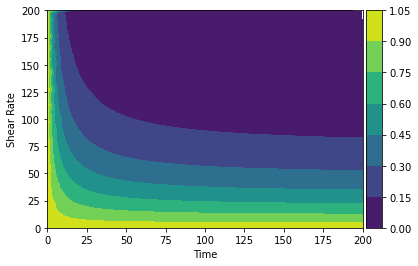

In [5]:
fig, ax = plt.subplots()
h=ax.contourf(grid_x,grid_y, grid_ext,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('Time')
plt.ylabel('Shear Rate')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('solution.png',dpi=600,bbox_inches = 'tight')

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  


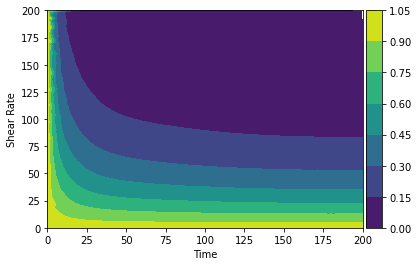

In [6]:
fig, ax = plt.subplots()
h=ax.contourf(grid_x,grid_y, grid_pre,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('Time')
plt.ylabel('Shear Rate')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('prediction.png',dpi=600,bbox_inches = 'tight')

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  


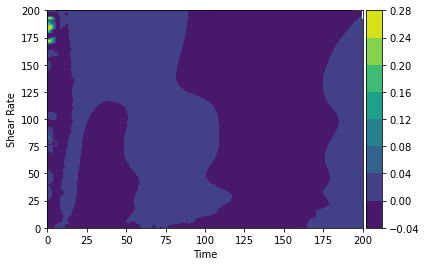

In [7]:
fig, ax = plt.subplots()
h=ax.contourf(grid_x,grid_y, grid_err,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('Time')
plt.ylabel('Shear Rate')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('error.png',dpi=600,bbox_inches = 'tight')

# Test

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  # This is added back by InteractiveShellApp.init_path()


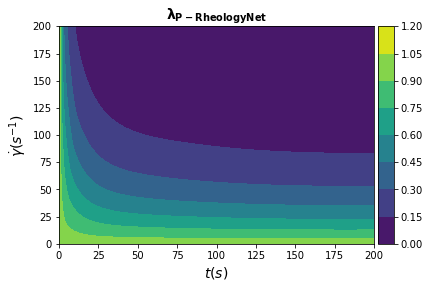

In [20]:
x = np.linspace(0, 200, 200)
t = np.linspace(0, 200, 200)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

pre = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

fig, ax = plt.subplots()
h=ax.contourf(X,T, pre,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('$t(s)$',fontproperties = 'Times New Roman', size = 14)
plt.ylabel('$\dot{\gamma } ( s^{-1}) $ ',fontproperties = 'Times New Roman', size = 14 )
plt.title('$\mathbf{\lambda _{P-RheologyNet}}$ ',fontproperties = 'Times New Roman', size = 14)


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('pinn_of_λ.png',dpi=600,bbox_inches = 'tight')

# exact solution

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  """


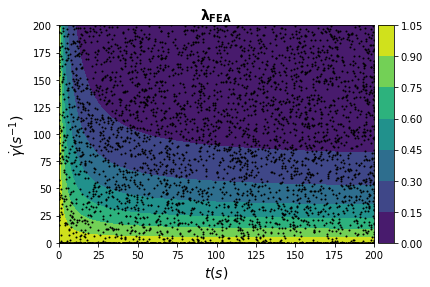

In [9]:
train1=np.loadtxt('train.dat', unpack = True)
train1 = pd.DataFrame(train1.T)
ext = griddata(X_star, solution1(X_star[:,0],X_star[:,1]), (X, T), method="cubic")
fig, ax = plt.subplots()
h=ax.contourf(X,T, ext,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('$t(s)$',fontproperties = 'Times New Roman', size = 14)
plt.ylabel('$\dot{\gamma } ( s^{-1}) $ ',fontproperties = 'Times New Roman', size = 14 )
plt.title('$\mathbf{\lambda _{FEA}}$ ',fontproperties = 'Times New Roman', size = 14)
plt.scatter(train1[0],train1[1],c='black',s=1)


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('solution_of_λ.png',dpi=600,bbox_inches = 'tight')



/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  This is separate from the ipykernel package so we can avoid doing imports until


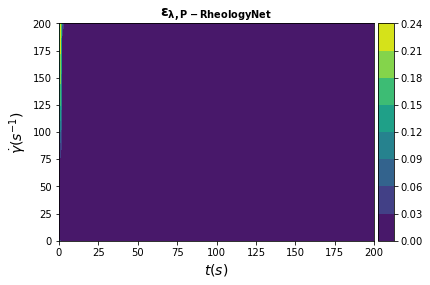

In [19]:
err=abs(pre-ext)
fig, ax = plt.subplots()
h=ax.contourf(X,T, err,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('$t(s)$',fontproperties = 'Times New Roman', size = 14)
plt.ylabel('$\dot{\gamma } ( s^{-1}) $ ',fontproperties = 'Times New Roman', size = 14 )

plt.title(r'$\mathbf{\varepsilon_{\lambda ,P-RheologyNet} }$ ',fontproperties = 'Times New Roman', size = 14 )

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('pinn_err_λ.png',dpi=600,bbox_inches = 'tight')

In [11]:
train=np.loadtxt('train.dat', unpack = True)
df = pd.DataFrame(train.T)
df

,0,1,2
0,0.000000,107.220711,1.000000
1,0.000000,180.024841,1.000000
2,0.000000,162.627090,1.000000
3,0.000000,53.559216,1.000000
4,0.000000,160.370956,1.000000
...,...,...,...
4837,61.042946,27.098406,0.590074
4838,84.356850,96.800613,0.134527
4839,39.700684,160.442841,0.061193
4840,67.733307,70.349297,0.246652


/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'


Text(23.875, 0.5, 'shear rate')

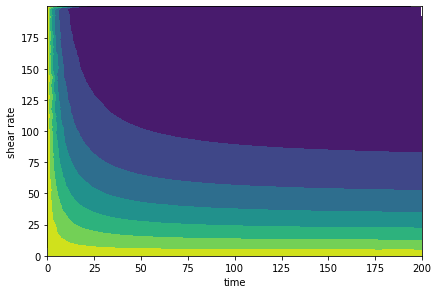

In [12]:
import pandas as pd
train=np.loadtxt('train.dat', unpack = True)
# train= pd.DataFrame(train.T)
# test1=np.loadtxt('test.dat', unpack = True)
df = pd.DataFrame(train.T, columns = ['x','y','u'])
x = df['x']
y = df['y']
z = df['u']
from scipy.interpolate import griddata
N = 1000; 
#npts = 2000*2000

grid_x,grid_y = np.meshgrid(np.linspace(x.min(),x.max(),N),np.linspace(y.min(),y.max(),N))
# grid_x1,grid_y1 = np.meshgrid(np.linspace(0,1,500),np.linspace(0,1,500))

#px, py = np.random.choice(x, npts), np.random.choice(y, npts)
grid_z1 = griddata((x,y) ,z, (grid_x, grid_y), method='linear')

rng = np.random.default_rng()
# points = rng.random((1000, 2))

# a=np.zeros(1000)
# a[:]=np.nan
# grid_z2 = griddata(points ,  a , (grid_x1, grid_y1), method='cubic')
#grid_z1[999:2000,999:2000]=0
#scipy.interpolate.griddata(X,Y,X**2+Y**2,XI,YI)
plt.contourf(grid_x,grid_y, grid_z1,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
# plt.scatter(train1[0],train1[1],c='red',s=1)
# plt.scatter(test1[0],test1[1],c='black',s=1)
# plt.axis('equal')
plt.tight_layout()
# plt.axis('off')
plt.xlabel('time')
plt.xlim(0,200)
plt.ylabel('shear rate')


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

train=np.loadtxt('train.dat', unpack = True)
x_train = train[[0,1]].T
y_train = train[2]

clf = MLPRegressor(hidden_layer_sizes=(50,50,50),max_iter=50000)

clf.fit(x_train, y_train)


MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=50000)

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  if sys.path[0] == '':


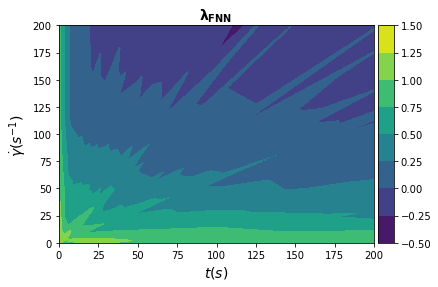

In [14]:
x = np.linspace(0, 200, 200)
t = np.linspace(0, 200, 200)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

prediction = clf.predict(X_star)

pre_nn = griddata(X_star, prediction, (X, T), method="cubic")

fig, ax = plt.subplots()
h=ax.contourf(X,T, pre_nn,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('$t(s)$',fontproperties = 'Times New Roman', size = 14)
plt.ylabel('$\dot{\gamma } ( s^{-1}) $ ',fontproperties = 'Times New Roman', size = 14 )
plt.title('$\mathbf{\lambda _{FNN}}$ ',fontproperties = 'Times New Roman', size = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('FNN_pre.png',dpi=600,bbox_inches = 'tight')

/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  This is separate from the ipykernel package so we can avoid doing imports until


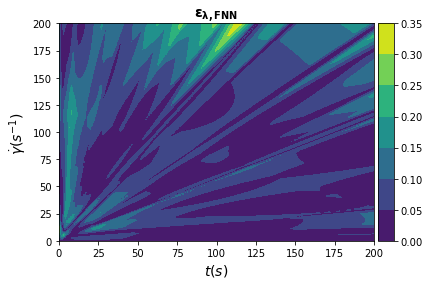

In [15]:
err_nn = abs(pre_nn-ext)
fig, ax = plt.subplots()
h=ax.contourf(X,T, err_nn,cmap="viridis",origin='lower', aspect='auto',interpolation='nearest')
plt.xlabel('$t(s)$',fontproperties = 'Times New Roman', size = 14)
plt.ylabel('$\dot{\gamma } ( s^{-1}) $ ',fontproperties = 'Times New Roman', size = 14 )
plt.title(r'$\mathbf{\varepsilon_{\lambda ,FNN} }$ ',fontproperties = 'Times New Roman', size = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig('FNN_err.png',dpi=600,bbox_inches = 'tight')

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(pre,ext)

9.415250787850087e-05

In [17]:
mean_squared_error(pre_nn,ext)

0.00640988760466726

([<matplotlib.axis.XTick at 0x7ff1a6d02b90>,
 [Text(1, 0, 'RheologyNet'),
  Text(2, 0, 'FNN'),
  Text(3, 0, 'Rhe'),
  Text(4, 0, 'N')])

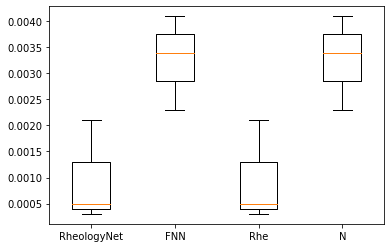

In [18]:
d={'RheologyNet of lambda':[0.0003,0.0021,0.0005],'FNN of lambda':[0.0023,0.0034,0.0041],'RheologyNet of shear':[0.0003,0.0021,0.0005],'FNN of shear':[0.0023,0.0034,0.0041]}
data=pd.DataFrame(data=d)
plt.boxplot(data)
plt.xticks([1,2,3,4],['RheologyNet','FNN','Rhe','N'])
# plt.yscale('log')
# plt.ylim(0,1)
